# SDR: Sample Rate Conversion oder Wie man richtig dezimiert und interpoliert (und wie man es nicht machen soll)

Oft ist die Samplerate von digitalisierten Signalen zu hoch für die Weiterverarbeitung, und man benötigt auch oft nicht die volle Bandbreite eines Signals für die Weiterverarbeitung.
Umgekehrt kann es sein, dass die Samplerate eines Signals zu niedrig ist, und man möchte die Datenrate erhöhen, weil erst dann die Weiterverarbeitung möglich wird.
Ein Beispiel für den ersten Fall ist ein Digital-Down-Converter (DDC), wie er in den vielen Software-Defined-Radios eingebaut ist, hier am Beispiel des HERMES/HPSDR:

[hier klicken für das DDC-Blockschaltbild](https://dm1cr.de/wp-content/uploads/2020/07/DDC.png)

Die Samplerate des ADC ist 122.8 Msps. Eine derart hohe Samplerate kann nicht direkt von einem PC verarbeitet werden (ok, mittlerweile könnten das aktuelle PCs vielleicht schon, aber zum Zeitpunkt der HERMES-Entwicklung (vor 2008) eher nicht), so dass zuerst der interessierende Teil des Spektrums mithilfe eines NCO (numerically controlled oscillator) und eines IQ-Mischers (genauer gesagt, wird das Multiplizieren mit einem Sinus und einem Cosinus mit einem CORDIC-Algorithmus iteriert und es muss nur der Phasenakkumulator-Wert eingefüttert werden, aber das ist ein eigenes Thema) in das Basisband verschoben wird und dann das Nutzspektrum mithilfe eines Tiefpassfilters herausgeschnitten wird.
Das dezimierende Tiefpassfilter, das hier als ein Block gezeichnet ist, ist dabei in Wirklichkeit mehrstufig aufgebaut. Nach jeder Stufe wird die Samplerate reduziert, bis man am Ausgang eine Samplerate erhält, die sowohl zum PC übertragen werden kann als auch zur Demodulation weiterverarbeitet werden kann. Die Ausgangs-Samplerate kann dabei zwischen 192 ksps, 96 ksps oder 48 ksps gewählt werden. Gleichzeitig wird übrigens durch die Mittelungs-Funktion des Filters die vertikale Auflösung der Daten erhöht, d.h. die Bit-Breite; ein Effekt, der bei anderen Systemen, z.B. dem ADALM-Pluto, noch viel stärker ausgenützt wird als beim HERMES. Der genaue Aufbau und die Funktionsweise des Filters ist ebenfalls ein eigenes Thema.

Ein Beispiel für den zweiten Fall ist ein Digital-Up-Converter (DUC), wieder gezeigt am Beispiel des HERMES/HPSDR:

[hier klicken für das DUC-Blockschaltbild](https://dm1cr.de/wp-content/uploads/2020/07/DUC.png)

Hier geht der Signalfluss in die umgekehrte Richtung: Vom PC kommen I-Q-Daten, die in mehreren Schritten auf eine Samplerate von 122.88 Msps hochgerechnet werden. Weil aber die I-Q-Daten vom PC eine Samplerate von nur 192/96/48 ksps haben, müssen die Werte für die fehlenden Samples interpoliert werden, daher der Name "interpolating filters". 

Im Buch *Software Defined Radio for Engineers*, das man [hier](https://www.analog.com/en/education/education-library/software-defined-radio-for-engineers.html) angucken kann, und im zugehörigen [Github-Repository](https://github.com/sdrforengineers) findet man zu Kapitel 2.2.5 das Skript *updownsample.m*, das ich versucht habe, in Python umzusetzen:

Zunächst werden die notwendigen Bibliotheken importiert und eine Warnung vor zu vielen Grafikfenstern abgeschaltet 

In [3]:
import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning = 0)
import numpy as np
from scipy.signal import find_peaks_cwt, firls, lfilter, upfirdn

Als Nächstes definieren wir eine Funktion zum Darstellen von Samples im Zeitbereich:

In [4]:
def time_plot(ax, x1, x2, txtsize, ltxtsize, pwidth, pheight, pxoffset,
    pyoffset, markersize, titlestr):
    ax.set_xlabel('Discrete Time (n)')
    ax.set_ylabel('Signal Amplitude')
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(x1, x2)
    ax.set_title(titlestr)

Im Folgenden werden eine Funktion und 2 Hilfsfunktionen zur Transformation und Darstellung im Frequenzbereich definiert.
Diese insgesamt 4 Funktionen werden wir später noch einige Male zum Plotten brauchen:

In [5]:
def fft_plot(ax, data, points, txtsize, ltxtsize, pwidth, pheight,
                      pxoffset, pyoffset, markersize, titlestr, units):
    fft_data = do_fft(data)
    fft_axis = do_fs(data)
    ydata = fft_data[np.int32(len(data)/2):len(data)]
    xdata = fft_axis[np.int32(len(data)/2):len(data)]
    peakind = find_peaks_cwt(xdata, np.arange(1,10))
    psor=ydata[peakind]
    lsor=xdata[peakind]
    if np.mean(psor) > -23:
        (M,I) = min(lsor)
        ax.plot(fft_axis, fft_data, lsor(I), psor(I), 'o')
        ax.set_xlabel(r'$\frac{f_s}{2}$')
        tstr = '%2.1fdB @ %.3f' % (psor(I), lsor(I))
        ax.set_text(lsor[I]+.02, psor[I], tstr + r'$\frac{f_s}{2}$')
    else:
        ax.plot(fft_axis, fft_data)
    ax.set_xlabel( 'Frequency ' + units)
    ax.set_ylabel('Signal Amplitude (dB)')
    ax.set_ylim(-200, 0)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks((-.5, -.25,  0,  .25,  .5))
    ax.grid(b=True)
    ax.set_title(titlestr)
    
def do_fft(indata):
    L = len(indata) # Window Length of FFT
    in_HannWnd = indata * np.hanning(L)
    out=20*(np.log10(np.abs(np.fft.fftshift(np.fft.fft(in_HannWnd,L))/(L/2))))
    return out

def do_fs(indata):
    out = (np.arange(0,len(indata),1)/(0.5*len(indata))-1)/2
    return out

Jetzt werden einige Grundeinstellungen für's Plotten vorgenommen:

In [6]:
# Specify plot parameters
txtsize=20
ltxtsize=9
pwidth=4 #4
pheight=4 #4
pxoffset=1 #0.65
pyoffset=1 #0.5
markersize=5 

fsizehor = 15
fsizever = 4

# number filter taps
taps = 127
# where to plot from
start = np.int32((taps/100)+1)*100
inc = 50

In den folgenden Zeilen wird die Samplerate definiert und ein Vektor, der die Abtastzeiten enthält.
Anschließend werden 2 Vektoren für Beispiel-Samplewerte berechnet.
Der erste Vektor, *sin_wave*, enthält einen Sinus als Beispiel für ein schmalbandiges Signal.
Der zweite Vektor, *random*, enthält Zufallsdaten (jeweils +1 oder -1) als Beispiel für ein breitbandiges Signal:

In [7]:
Fs1 = 10*2*np.pi
# Create deterministic and stochastic digital data streams:
n = np.arange(0, 100-(1/Fs1)+1, 1/Fs1)                # Time index vector
sin_wave = np.sin(5*n*2*np.pi)                        # Generation of sinusoidal signal
random = 2*np.around(np.random.rand(n.size))-1        # Random string of +1/-1 values

Im nächsten Code-Abschnitt werden die beiden Signale geplottet:

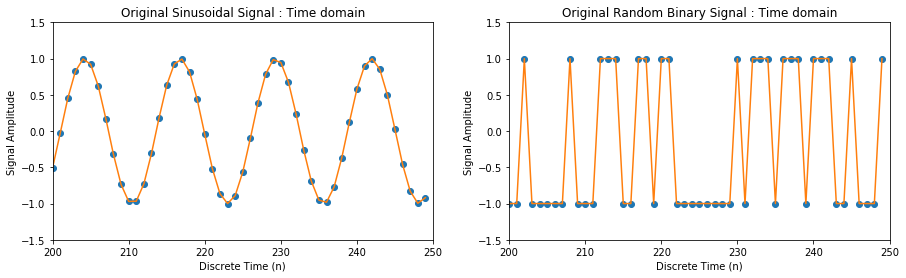

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[start:start+inc]*Fs1, sin_wave[start:start+inc], 'o',
    n[start:start+inc]*Fs1, sin_wave[start:start+inc])
time_plot(ax1, start, start+inc, txtsize, ltxtsize, pwidth, pheight, pxoffset,
          pyoffset, markersize,
          'Original Sinusoidal Signal : Time domain')

ax2.plot(n[start:start+inc]*Fs1, random[start:start+inc],'o',
    n[start:start+inc]*Fs1, random[start:start+inc])
time_plot(ax2, start, start+inc, txtsize, ltxtsize, pwidth, pheight, pxoffset,
          pyoffset, markersize,
          'Original Random Binary Signal : Time domain')

Der darauffolgende Code-Abschnitt plottet die beiden Signale im Frequenzbereich:

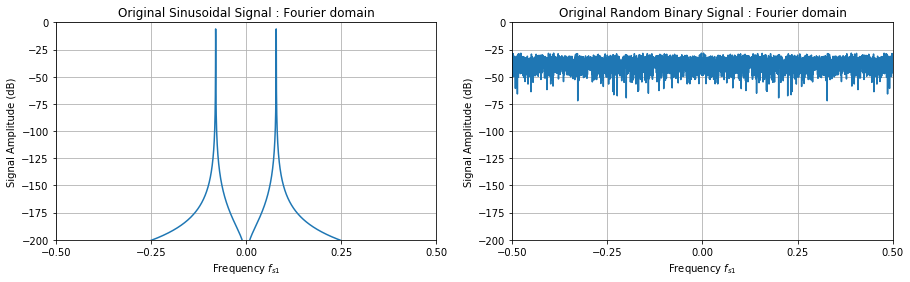

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))

fft_plot(ax1, sin_wave[start:], 1, txtsize, ltxtsize, pwidth, pheight,
    pxoffset,  pyoffset, markersize,
    'Original Sinusoidal Signal : Fourier domain', r'$f_{s1}$')
         
fft_plot(ax2, random[start:], 1, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Original Random Binary Signal : Fourier domain', r'$f_{s1}$')

Die Signale sollen jetzt in ihrer Bandbreite begrenzt werden. Um das zu tun, sollen sie ein FIR-Filter durchlaufen.
Die SciPy-Bibliothek stellt für die Koeffizienten-Berechnung die Funktion [scipy-signal.firls()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) zur Verfügung und für das eigentliche Ausführen der Filterung mit den vorher berechneten Koeffizienten die Funktion [scipy.signal.lfilter()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html):

In [10]:
# Create lowpass filter and apply it to both data streams
coeffs1 = firls(taps,(0,0.2,0.22,1),(1,1,0,0)) # FIR filter coefficients
sin_bwlimited = lfilter(coeffs1,1,sin_wave)
random_bwlimited = lfilter(coeffs1,1,random)

Die gefilterten Daten werden durch die folgenden Codezeilen sowohl im Zeitbereich als auch im Frequenzbereich geplottet:

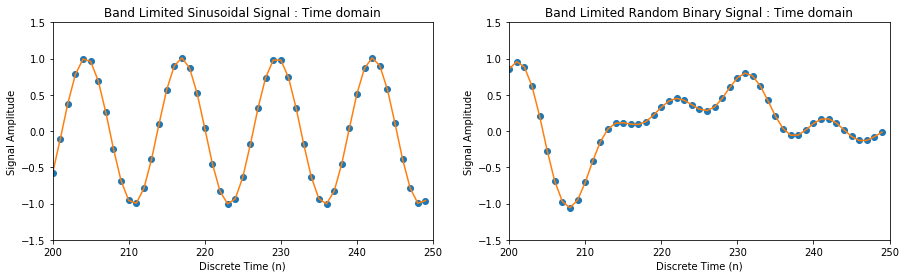

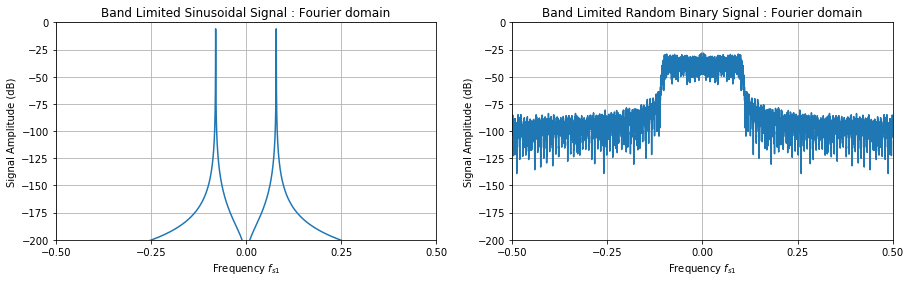

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[start:start+inc]*Fs1, sin_bwlimited[start:start+inc], 'o',
        n[start:start+inc]*Fs1, sin_bwlimited[start:start+inc])
time_plot(ax1, start, start+inc, txtsize, ltxtsize, pwidth, pheight, pxoffset,
    pyoffset, markersize, 'Band Limited Sinusoidal Signal : Time domain')

ax2.plot(n[start:start+inc]*Fs1, random_bwlimited[start:start+inc],'o',
        n[start:start+inc]*Fs1, random_bwlimited[start:start+inc])
time_plot(ax2, start, start+inc, txtsize, ltxtsize, pwidth, pheight, pxoffset,
    pyoffset, markersize, 'Band Limited Random Binary Signal : Time domain')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
fft_plot(ax1, sin_bwlimited[start:], 1, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Band Limited Sinusoidal Signal : Fourier domain', r'$f_{s1}$')

fft_plot(ax2, random_bwlimited[start:], 1, txtsize, ltxtsize, pwidth,
    pheight, pxoffset, pyoffset, markersize,
    'Band Limited Random Binary Signal : Fourier domain', r'$f_{s1}$')

Wie man feststellen kann, ändert sich für das bandbreitenbegrenzte Signal nichts, weil dessen spektrale Leistung innerhalb der Bandbreite des Filters liegt. Bei dem breitbandigen Zufallsignal ist das nicht so, und das Filter verändert das Signal sowohl im Zeitbereich als auch im Frequenzbereich.

## Upsampling und Downsampling (fälschlicherweise ohne zu Filtern)

Die beiden Testdatensätze sollen zu Demonstrationszwecken um den Faktor 5 in der Abtastrate erhöht werden (5-faches Umsampling) und anschließend um den Faktor 3 in der Abtastrate erniedrigt werden (3-faches Downsampling), um insgesamt eine Abtastratenerhöhung von 5/3 zu erreichen.
Um zu sehen, was eine korrekte Filterung bewirkt, werden die eigentlich notwendigen Filterungen zunächst weggelassen.

### Upsampling mit N = 5

Für's Upsampling, d.h. für die Erhöhung der Samplerate, stellt SciPy die Funktion *[upfirdn()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.upfirdn.html)* zur Verfügung. Wie der Name suggeriert, kann die Funktion noch mehr, wir benutzen sie aber nur für das Einfügen von (N-1) Nullen zwischen den Abtastwerten, um im Ergebnis die N-fache Anzahl von Abtastwerten zu bekommen:

In [12]:
N = 5
sin_up = upfirdn([1], sin_bwlimited, up=N)
random_up = upfirdn([1], random_bwlimited, up=N)
Fs2 = Fs1 * N

Wie man sich vorstellen kann, kann es mit dem Einfügen von Nullen noch nicht getan sein.
Wir schauen uns mal an, wie die Daten im Zeitbereich und im Frequenzbereich jetzt aussehen:

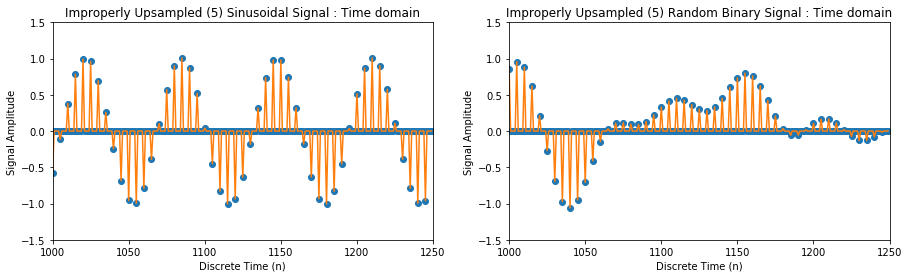

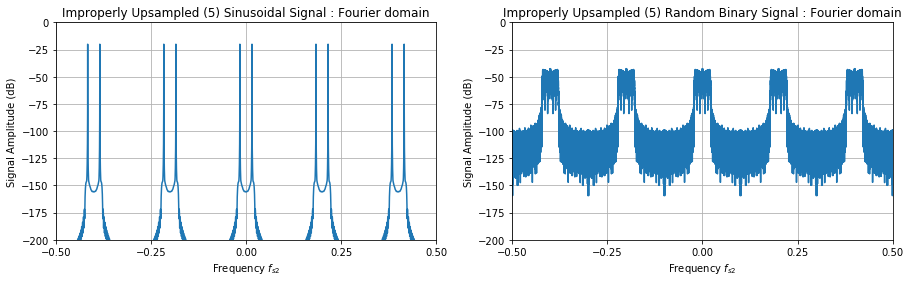

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[start*N:(start+inc)*N]*Fs1, sin_up[start*N:(start+inc)*N], 'o',
        n[start*N:(start+inc)*N]*Fs1, sin_up[start*N:(start+inc)*N])
time_plot(ax1,start*N, (start+inc)*N, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Improperly Upsampled (%d) Sinusoidal Signal : Time domain' % N)

ax2.plot(n[start*N:(start+inc)*N]*Fs1, random_up[start*N:(start+inc)*N],'o',
        n[start*N:(start+inc)*N]*Fs1, random_up[start*N:(start+inc)*N])
time_plot(ax2, start*N, (start+inc)*N, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Improperly Upsampled (%d) Random Binary Signal : Time domain' % N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
fft_plot(ax1, sin_up[start:], N, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Improperly Upsampled (%d) Sinusoidal Signal : Fourier domain' % N,
    r'$f_{s2}$')

fft_plot(ax2, random_up[start:], N, txtsize, ltxtsize, pwidth, pheight,
    pxoffset, pyoffset, markersize,
    'Improperly Upsampled (%d) Random Binary Signal : Fourier domain' % N,
    r'$f_{s2}$')

### Downsampling mit M = 3

Wir benutzen die vorher 5-fach abtastratenerhöhten Datensätze im nächsten Schritt zum Erniedrigen der Abtastraten um den Faktor 3.
Um zu Demonstrieren, welche Artefakte ohne Filterung auftreten, wird die eigentlich notwendige Filterung weggelassen:

In [14]:
# Attempt to downsampling by M without filtering
# This is incorrect, but is instructive to show what artifacts occur
M = 3
sin_up_down = upfirdn([1], sin_up, down=M)
random_up_down = upfirdn([1], random_up, down=M)
Fs3 = Fs2/M

Die Datensätze werden wieder im Zeitbereich und im Frequenzbereich geplottet:

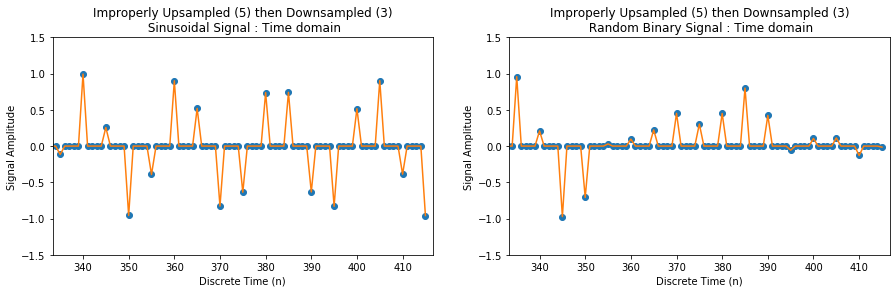

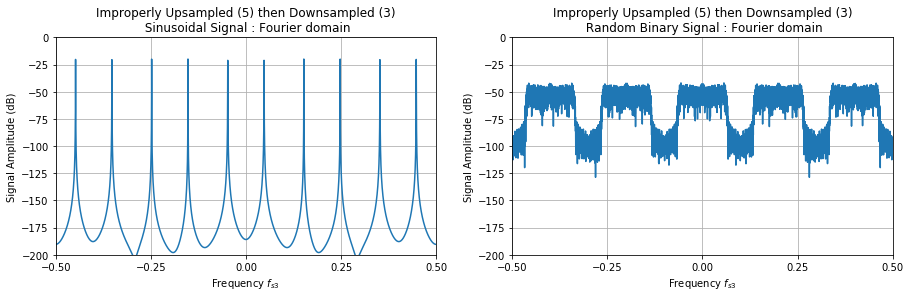

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         sin_up_down[int(start*N/M):int((start+inc)*N/M)], 'o',
        n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         sin_up_down[int(start*N/M):int((start+inc)*N/M)])
time_plot(ax1, start*N/M, (start+inc)*N/M, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Improperly Upsampled (%d) then Downsampled (%d)\n '\
          'Sinusoidal Signal : Time domain' % (N, M))

ax2.plot(n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
     random_up_down[int(start*N/M):int((start+inc)*N/M)],'o',
        n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
     random_up_down[int(start*N/M):int((start+inc)*N/M)])
time_plot(ax2, start*N/M, (start+inc)*N/M, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Improperly Upsampled (%d) then Downsampled (%d)\n '\
          'Random Binary Signal : Time domain' % (N, M))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
fft_plot(ax1, sin_up_down[start:], N, txtsize, ltxtsize, pwidth, pheight,
         pxoffset, pyoffset, markersize,
         'Improperly Upsampled (%d) then Downsampled (%d)\n '\
         'Sinusoidal Signal : Fourier domain' % (N, M), r'$f_{s3}$')

fft_plot(ax2, random_up_down[start:], N, txtsize, ltxtsize, pwidth, pheight,
         pxoffset, pyoffset, markersize,
         'Improperly Upsampled (%d) then Downsampled (%d)\n '\
         'Random Binary Signal : Fourier domain' % (N, M), r'$f_{s3}$')

## Upsampling und Downsampling (richtige Methode)

Die um den Faktor N=5 abtastratenerhöhten Signale werden tiefpassgefiltert. Dadurch verschwinden die eingefügten Nullen und werden durch interpolierte Datenwerte ersetzt.
Anschließend werden die Daten um den Faktor M=3 dezimiert.
Weil das Filtern eine zeitliche Verzögerung der Daten bewirkt, soll das Plotten der Daten erst nach der Verzögerung des Filters beginnen:

In [18]:
# Lowpass filtering of baseband periodic replica followed by downsampling
# (correct approach)
coeffs2 = firls(taps,(0,0.15,0.25,1),(N,N,0,0)) # FIR filter coefficients
sin_up_filtered = lfilter(coeffs2,1,sin_up)
sin_up_filtered_down = upfirdn([1], sin_up_filtered, down=M)
random_up_filtered = lfilter(coeffs2,1,random_up)
random_up_filtered_down = upfirdn([1], random_up_filtered, down=M)
start = start + np.int32(taps/(2*N))

Die um 5/3 insgesamt abtastratenerhöhten Daten liegen jetzt vor und können geplottet werden:

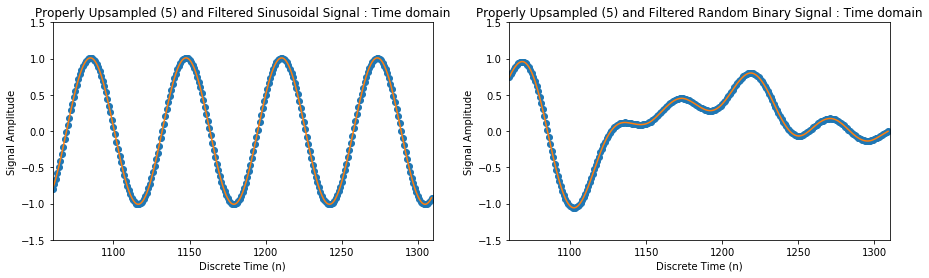

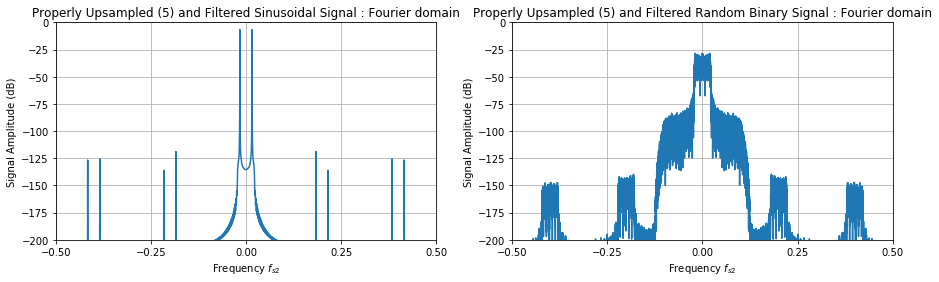

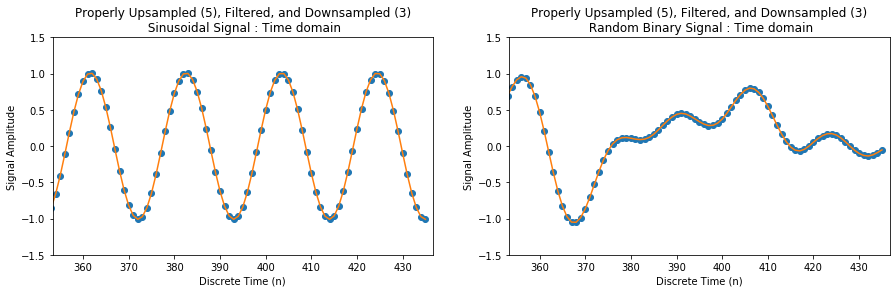

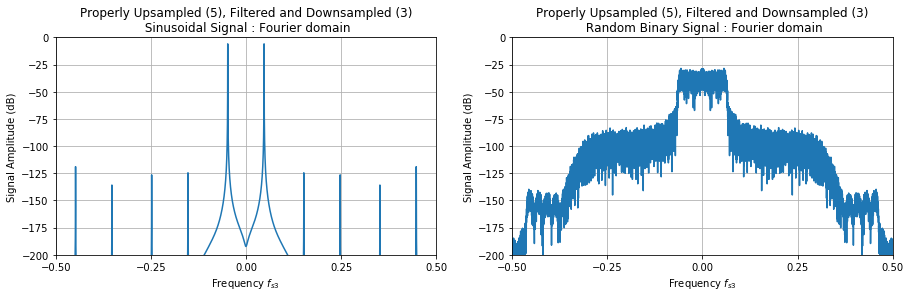

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[start*N:(start+inc)*N]*Fs1,
           sin_up_filtered[start*N:(start+inc)*N], 'o',
        n[start*N:(start+inc)*N]*Fs1,
           sin_up_filtered[start*N:(start+inc)*N])
time_plot(ax1, start*N, (start+inc)*N, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Properly Upsampled (%d) and Filtered '\
          'Sinusoidal Signal : Time domain' % N)

ax2.plot(n[start*N:(start+inc)*N]*Fs1,
           random_up_filtered[start*N:(start+inc)*N],'o',
        n[start*N:(start+inc)*N]*Fs1,
           random_up_filtered[start*N:(start+inc)*N])
time_plot(ax2, start*N, (start+inc)*N, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Properly Upsampled (%d) and Filtered '\
          'Random Binary Signal : Time domain' % N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
fft_plot(ax1, sin_up_filtered[start:], 1, txtsize, ltxtsize, pwidth, pheight,
         pxoffset, pyoffset, markersize,
         'Properly Upsampled (%d) and Filtered '\
         'Sinusoidal Signal : Fourier domain' % N, r'$f_{s2}$')

fft_plot(ax2, random_up_filtered[start:], 1, txtsize, ltxtsize, pwidth, pheight,
         pxoffset, pyoffset, markersize,
         'Properly Upsampled (%d) and Filtered '\
         'Random Binary Signal : Fourier domain' % N, r'$f_{s2}$')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
ax1.plot(n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         sin_up_filtered_down[int(start*N/M):int((start+inc)*N/M)], 'o',
         n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         sin_up_filtered_down[int(start*N/M):int((start+inc)*N/M)])
time_plot(ax1, start*N/M, (start+inc)*N/M, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Properly Upsampled (%d), Filtered, and Downsampled (%d)\n '\
          'Sinusoidal Signal : Time domain' % (N, M))

ax2.plot(n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         random_up_filtered_down[int(start*N/M):int((start+inc)*N/M)], 'o',
         n[int(start*N/M):int((start+inc)*N/M)]*Fs1,
         random_up_filtered_down[int(start*N/M):int((start+inc)*N/M)])
time_plot(ax2, start*N/M, (start+inc)*N/M, txtsize, ltxtsize, pwidth, pheight,
          pxoffset, pyoffset, markersize,
          'Properly Upsampled (%d), Filtered, and Downsampled (%d)\n '\
          'Random Binary Signal : Time domain' % (N, M))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fsizehor, fsizever))
fft_plot(ax1, sin_up_filtered_down[start:], 1, txtsize, ltxtsize, pwidth, pheight,
         pxoffset, pyoffset, markersize,
         'Properly Upsampled (%d), Filtered and Downsampled (%d)\n '\
         'Sinusoidal Signal : Fourier domain' % (N, M), r'$f_{s3}$')

fft_plot(ax2, random_up_filtered_down[start:], 1, txtsize, ltxtsize, pwidth,
         pheight, pxoffset, pyoffset, markersize,
         'Properly Upsampled (%d), Filtered and Downsampled (%d)\n '\
         'Random Binary Signal : Fourier domain' % (N,M), r'$f_{s3}$')

Das war's!